## Importing Lib

In [ ]:
import torch, torchvision
import os
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive/', force_remount=True)

device = ("cuda" if torch.cuda.is_available() else "cpu")
device


Mounted at /content/gdrive/


'cuda'

## Preparing Data

In [ ]:
!ls "gdrive/MyDrive/archive/"

pokemon  pokemon_jpg


In [ ]:
def get_data(path, img_size=64, batch_size=128):
  transform = T.Compose(
    [
      T.Resize(img_size),
      T.CenterCrop(img_size),
      T.ToTensor(),
      T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
  )

  dataset = ImageFolder(path, transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size,  shuffle=True, num_workers=4, pin_memory=True)
  return dataloader


In [ ]:
path = "gdrive/MyDrive/archive/pokemon_jpg"
data = get_data(path)

In [ ]:
def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_xticks([])
    ax.imshow(make_grid(images.detach(), nrow=12).permute(1,2,0).cpu().numpy())

def show_batch(dl, nmax=128):
    for images, _ in dl:
        show_images(images, nmax)
        break

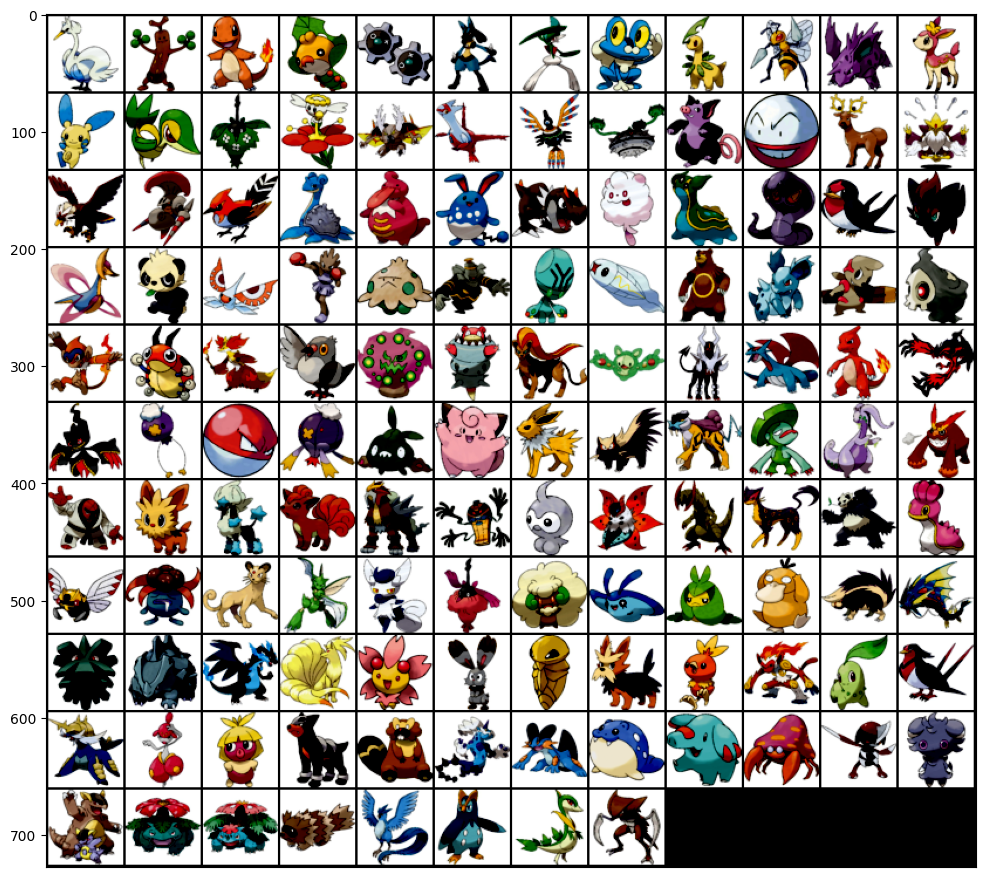

In [ ]:
show_batch(data)

## Network

In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    # First layer
    self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.relu1 = nn.LeakyReLU(0.2, inplace=True)

    #Second Layer
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)
    self.batchnorm2 = nn.BatchNorm2d(128)
    self.relu2 = nn.LeakyReLU(0.2, inplace=True)

    #Third Layer
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
    self.batchnorm3 = nn.BatchNorm2d(256)
    self.relu3 = nn.LeakyReLU(0.2, inplace=True)

    #Forth Layer
    self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
    self.batchnorm4 = nn.BatchNorm2d(512)
    self.relu4 = nn.LeakyReLU(0.2, inplace=True)

    # Fully Connected Layers
    self.fc1 = nn.Linear(512*4*4, 512)
    self.relu5 = nn.LeakyReLU(0.2, inplace=True)

    self.fc2 = nn.Linear(512, 1)
    self.sigmoid = nn.Sigmoid()



  def forward(self, x):
    # First Layer
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = self.relu1(x)

    # Second Layer
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = self.relu2(x)

    # Third Layer
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = self.relu3(x)

    # Fourth Layer
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = self.relu4(x)

    x = x.view(-1, 512*4*4)
    x = self.fc1(x)
    x = self.relu5(x)

    x = self.fc2(x)
    x = self.sigmoid(x)
    return x


In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_size):
    # 2 4 8 16 32 64 128 256 512 1024
    super(Generator, self).__init__()
    self.latent_size = latent_size
    self.main = nn.Sequential(
        nn.ConvTranspose2d(self.latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256*2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(256*2, 128*4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(128*4, 64*8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(64*8, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, z):
    z = z.view(z.size(0), z.size(1), 1, 1)
    x = self.main(z)
    return x




## Train GAN Network

In [ ]:
class GAN:

  def __init__(self, lr, latent_size, max_epochs, batch_size, X):
    self.lr = lr
    self.X = X
    self.max_epochs = max_epochs
    self.batch_size = batch_size
    self.latent_size = latent_size
    self.fixed_latent = torch.randn(64, self.latent_size, 1, 1, device=device)

    # Init the two networks
    self.generator = Generator(self.latent_size).to(device)
    self.discriminator = Discriminator().to(device)
    self.criterion = nn.BCELoss()


  def train_discriminator(self, real_imgs, optim):
    optim.zero_grad()

    # Train discriminator on real images
    real_outputs = self.discriminator(real_imgs)
    real_targets = torch.ones(real_imgs.size(0), 1, device=device)
    real_loss = self.criterion(real_outputs, real_targets)
    real_score = torch.mean(real_outputs).item()
    # real_loss.backward()


    # Train discriminator on fake images
    latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=device)
    fake_imgs = self.generator(latent)

    fake_outputs = self.discriminator(fake_imgs)
    fake_targets = torch.zeros(fake_imgs.size(0), 1, device=device)
    fake_loss = self.criterion(fake_outputs,  fake_targets)
    fake_score = torch.mean(fake_outputs).item()
    # fake_loss.backward()



    total_loss = real_loss + fake_loss
    total_loss.backward()
    optim.step()

    return total_loss.item(), real_score, fake_score

  def train_generator(self, optim):
    optim.zero_grad()

    latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=device)
    fake_imgs = self.generator(latent)

    fake_outputs = self.discriminator(fake_imgs)
    fake_targets = torch.ones(self.batch_size, 1, device=device)
    generator_loss = self.criterion(fake_outputs, fake_targets)

    generator_loss.backward()
    optim.step()

    return generator_loss.item()

  def save_images(self, idx, latent, path):
    fake_images = self.generator(latent)
    fname = 'pokemon_generated_{0:0=4d}.png'.format(idx)
    save_image(fake_images, os.path.join(path, fname), nrow=8)
    print("Saved", fname)



  def show_images(self, fake_images):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1,2,0))
    plt.show()

  def train_network(self, path):
    torch.cuda.empty_cache()

    # Losses and score
    generator_losses = []
    discriminator_losses = []
    real_scores = []
    fake_scores = []

    # Init optimizer
    discriminator_optim = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(0.5, 0.999))
    generator_optim = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.5, 0.999))

    for epoch in range(self.max_epochs):
      for real_images, _ in tqdm(self.X):

        # Train discriminator
        discriminator_loss, real_score, fake_score = self.train_discriminator(real_images, discriminator_optim)

        # Train generator
        generator_loss = self.train_generator(generator_optim)

      generator_losses.append(generator_loss)
      discriminator_losses.append(discriminator_loss)
      real_scores.append(real_score)
      fake_scores.append(fake_score)


      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, self.max_epochs, generator_loss, discriminator_loss, real_score, fake_score))
      self.save_images(idx=epoch+1, latent=self.fixed_latent, path=path)

    return generator_losses, discriminator_losses, real_scores, fake_scores



In [ ]:
# This is put the input data onto the GPU as our models are on the GPU
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
path

'gdrive/MyDrive/archive/pokemon_jpg'

In [ ]:
train_dl = get_data(path)
train_dl = DeviceDataLoader(train_dl, device)


In [ ]:
lr = 0.0002
latent_size = 100
max_epochs = 400
batch_size = 128
# X = Dataset(data, device)
gan = GAN(lr=lr, latent_size=latent_size, max_epochs=max_epochs, batch_size=batch_size, X=train_dl)

In [ ]:
!rm -rf gan_pokemon
new_path = "gan_pokemon"
os.makedirs(new_path, exist_ok=True)
# gan.train_network(path=new_path)

In [ ]:
generator_losses, discriminator_losses, real_scores, fake_scores = gan.train_network(path=new_path)

100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [1/400], loss_g: 5.5402, loss_d: 0.4134, real_score: 0.7305, fake_score: 0.0417
Saved pokemon_generated_0001.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [2/400], loss_g: 7.2555, loss_d: 0.0219, real_score: 0.9902, fake_score: 0.0118
Saved pokemon_generated_0002.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [3/400], loss_g: 19.1203, loss_d: 0.1573, real_score: 0.9992, fake_score: 0.1418
Saved pokemon_generated_0003.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [4/400], loss_g: 18.9003, loss_d: 0.0005, real_score: 0.9995, fake_score: 0.0000
Saved pokemon_generated_0004.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [5/400], loss_g: 18.1359, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saved pokemon_generated_0005.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [6/400], loss_g: 19.8190, loss_d: 2.8312, real_score: 0.9992, fake_score: 0.8126
Saved pokemon_generated_0006.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [7/400], loss_g: 6.1860, loss_d: 0.3942, real_score: 0.8075, fake_score: 0.0382
Saved pokemon_generated_0007.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [8/400], loss_g: 7.8702, loss_d: 0.2592, real_score: 0.8058, fake_score: 0.0151
Saved pokemon_generated_0008.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [9/400], loss_g: 9.6098, loss_d: 1.3597, real_score: 0.9996, fake_score: 0.3969
Saved pokemon_generated_0009.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [10/400], loss_g: 12.5343, loss_d: 0.3802, real_score: 0.9811, fake_score: 0.2747
Saved pokemon_generated_0010.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [11/400], loss_g: 5.7920, loss_d: 0.1203, real_score: 0.9389, fake_score: 0.0357
Saved pokemon_generated_0011.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [12/400], loss_g: 12.0127, loss_d: 1.4140, real_score: 0.9602, fake_score: 0.4946
Saved pokemon_generated_0012.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [13/400], loss_g: 5.9367, loss_d: 0.0819, real_score: 0.9825, fake_score: 0.0591
Saved pokemon_generated_0013.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [14/400], loss_g: 8.2443, loss_d: 0.1932, real_score: 0.9398, fake_score: 0.1045
Saved pokemon_generated_0014.png


100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


Epoch [15/400], loss_g: 16.2832, loss_d: 1.1692, real_score: 0.9748, fake_score: 0.5128
Saved pokemon_generated_0015.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [16/400], loss_g: 3.1705, loss_d: 0.7737, real_score: 0.6460, fake_score: 0.2231
Saved pokemon_generated_0016.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [17/400], loss_g: 5.6416, loss_d: 1.1815, real_score: 0.9130, fake_score: 0.6236
Saved pokemon_generated_0017.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [18/400], loss_g: 4.4791, loss_d: 0.2211, real_score: 0.9281, fake_score: 0.1229
Saved pokemon_generated_0018.png


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [19/400], loss_g: 2.7322, loss_d: 1.2368, real_score: 0.9462, fake_score: 0.6117
Saved pokemon_generated_0019.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [20/400], loss_g: 2.1051, loss_d: 1.6509, real_score: 0.2633, fake_score: 0.0279
Saved pokemon_generated_0020.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [21/400], loss_g: 3.0950, loss_d: 0.4416, real_score: 0.7605, fake_score: 0.1154
Saved pokemon_generated_0021.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [22/400], loss_g: 2.2323, loss_d: 0.9110, real_score: 0.5247, fake_score: 0.0695
Saved pokemon_generated_0022.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [23/400], loss_g: 0.6163, loss_d: 1.5799, real_score: 0.2792, fake_score: 0.0660
Saved pokemon_generated_0023.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [24/400], loss_g: 1.4340, loss_d: 0.9951, real_score: 0.6055, fake_score: 0.3525
Saved pokemon_generated_0024.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [25/400], loss_g: 2.3705, loss_d: 1.1912, real_score: 0.6021, fake_score: 0.4426
Saved pokemon_generated_0025.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [26/400], loss_g: 3.4841, loss_d: 1.1088, real_score: 0.7755, fake_score: 0.5400
Saved pokemon_generated_0026.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [27/400], loss_g: 2.1181, loss_d: 1.2237, real_score: 0.6569, fake_score: 0.5288
Saved pokemon_generated_0027.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [28/400], loss_g: 2.3578, loss_d: 1.3851, real_score: 0.5971, fake_score: 0.5384
Saved pokemon_generated_0028.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [29/400], loss_g: 1.2792, loss_d: 1.5009, real_score: 0.3743, fake_score: 0.2933
Saved pokemon_generated_0029.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [30/400], loss_g: 2.7522, loss_d: 1.3865, real_score: 0.6193, fake_score: 0.5471
Saved pokemon_generated_0030.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [31/400], loss_g: 1.8191, loss_d: 1.0179, real_score: 0.4722, fake_score: 0.1772
Saved pokemon_generated_0031.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [32/400], loss_g: 2.3059, loss_d: 0.9529, real_score: 0.6402, fake_score: 0.3716
Saved pokemon_generated_0032.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [33/400], loss_g: 2.0316, loss_d: 0.9503, real_score: 0.5354, fake_score: 0.2541
Saved pokemon_generated_0033.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [34/400], loss_g: 1.6675, loss_d: 1.1591, real_score: 0.5829, fake_score: 0.4334
Saved pokemon_generated_0034.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [35/400], loss_g: 4.2267, loss_d: 1.3627, real_score: 0.8083, fake_score: 0.6552
Saved pokemon_generated_0035.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [36/400], loss_g: 2.2680, loss_d: 1.1486, real_score: 0.6138, fake_score: 0.4527
Saved pokemon_generated_0036.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [37/400], loss_g: 1.6718, loss_d: 0.7704, real_score: 0.6003, fake_score: 0.1991
Saved pokemon_generated_0037.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [38/400], loss_g: 3.0042, loss_d: 1.3203, real_score: 0.7955, fake_score: 0.6399
Saved pokemon_generated_0038.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [39/400], loss_g: 2.6958, loss_d: 1.0510, real_score: 0.7092, fake_score: 0.4872
Saved pokemon_generated_0039.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [40/400], loss_g: 1.6040, loss_d: 1.5674, real_score: 0.2315, fake_score: 0.0142
Saved pokemon_generated_0040.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [41/400], loss_g: 2.6343, loss_d: 0.9007, real_score: 0.9022, fake_score: 0.5279
Saved pokemon_generated_0041.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [42/400], loss_g: 0.9417, loss_d: 0.9403, real_score: 0.4622, fake_score: 0.0870
Saved pokemon_generated_0042.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [43/400], loss_g: 4.7573, loss_d: 0.9792, real_score: 0.8179, fake_score: 0.5164
Saved pokemon_generated_0043.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [44/400], loss_g: 2.2440, loss_d: 1.1419, real_score: 0.7973, fake_score: 0.5808
Saved pokemon_generated_0044.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [45/400], loss_g: 2.1343, loss_d: 0.7293, real_score: 0.7646, fake_score: 0.3432
Saved pokemon_generated_0045.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [46/400], loss_g: 1.3757, loss_d: 1.8705, real_score: 0.2061, fake_score: 0.0035
Saved pokemon_generated_0046.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [47/400], loss_g: 1.6636, loss_d: 1.0156, real_score: 0.7722, fake_score: 0.4948
Saved pokemon_generated_0047.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [48/400], loss_g: 2.1969, loss_d: 1.3080, real_score: 0.5062, fake_score: 0.4010
Saved pokemon_generated_0048.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [49/400], loss_g: 2.8989, loss_d: 0.7830, real_score: 0.9061, fake_score: 0.4516
Saved pokemon_generated_0049.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [50/400], loss_g: 1.8366, loss_d: 0.9637, real_score: 0.6136, fake_score: 0.3331
Saved pokemon_generated_0050.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [51/400], loss_g: 0.8200, loss_d: 3.9378, real_score: 0.0302, fake_score: 0.0027
Saved pokemon_generated_0051.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [52/400], loss_g: 1.6768, loss_d: 0.8753, real_score: 0.5997, fake_score: 0.2519
Saved pokemon_generated_0052.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [53/400], loss_g: 2.1479, loss_d: 1.0885, real_score: 0.5933, fake_score: 0.3784
Saved pokemon_generated_0053.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [54/400], loss_g: 1.9308, loss_d: 0.8521, real_score: 0.8519, fake_score: 0.4632
Saved pokemon_generated_0054.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [55/400], loss_g: 1.7304, loss_d: 0.8390, real_score: 0.7756, fake_score: 0.4185
Saved pokemon_generated_0055.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [56/400], loss_g: 2.2029, loss_d: 0.7968, real_score: 0.5776, fake_score: 0.1716
Saved pokemon_generated_0056.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [57/400], loss_g: 2.2800, loss_d: 0.8061, real_score: 0.6350, fake_score: 0.2691
Saved pokemon_generated_0057.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [58/400], loss_g: 2.4970, loss_d: 0.7939, real_score: 0.6958, fake_score: 0.3093
Saved pokemon_generated_0058.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [59/400], loss_g: 2.4166, loss_d: 0.8508, real_score: 0.6187, fake_score: 0.2638
Saved pokemon_generated_0059.png


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [60/400], loss_g: 1.5717, loss_d: 1.0431, real_score: 0.4704, fake_score: 0.1738
Saved pokemon_generated_0060.png


100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


Epoch [61/400], loss_g: 2.4318, loss_d: 0.6827, real_score: 0.7781, fake_score: 0.3165
Saved pokemon_generated_0061.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [62/400], loss_g: 3.1609, loss_d: 0.6673, real_score: 0.8304, fake_score: 0.3668
Saved pokemon_generated_0062.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [63/400], loss_g: 2.3554, loss_d: 0.8366, real_score: 0.7525, fake_score: 0.4007
Saved pokemon_generated_0063.png


100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


Epoch [64/400], loss_g: 3.4405, loss_d: 2.7208, real_score: 0.0886, fake_score: 0.0047
Saved pokemon_generated_0064.png


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Epoch [65/400], loss_g: 1.5056, loss_d: 1.1407, real_score: 0.4592, fake_score: 0.2514
Saved pokemon_generated_0065.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [66/400], loss_g: 2.4695, loss_d: 0.9095, real_score: 0.6723, fake_score: 0.3630
Saved pokemon_generated_0066.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [67/400], loss_g: 3.3804, loss_d: 1.3535, real_score: 0.8927, fake_score: 0.6731
Saved pokemon_generated_0067.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [68/400], loss_g: 3.3412, loss_d: 0.5966, real_score: 0.7731, fake_score: 0.2669
Saved pokemon_generated_0068.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [69/400], loss_g: 2.7966, loss_d: 0.5126, real_score: 0.6723, fake_score: 0.0832
Saved pokemon_generated_0069.png


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Epoch [70/400], loss_g: 2.8306, loss_d: 2.0968, real_score: 0.1571, fake_score: 0.0077
Saved pokemon_generated_0070.png


100%|██████████| 7/7 [00:03<00:00,  1.97it/s]


Epoch [71/400], loss_g: 2.1741, loss_d: 0.7814, real_score: 0.7003, fake_score: 0.3075
Saved pokemon_generated_0071.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [72/400], loss_g: 2.4027, loss_d: 0.9050, real_score: 0.7118, fake_score: 0.4014
Saved pokemon_generated_0072.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [73/400], loss_g: 2.6853, loss_d: 0.5187, real_score: 0.6889, fake_score: 0.0948
Saved pokemon_generated_0073.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [74/400], loss_g: 3.0638, loss_d: 1.1701, real_score: 0.9368, fake_score: 0.6368
Saved pokemon_generated_0074.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [75/400], loss_g: 2.4624, loss_d: 0.5659, real_score: 0.7810, fake_score: 0.2566
Saved pokemon_generated_0075.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [76/400], loss_g: 2.4392, loss_d: 0.9393, real_score: 0.6414, fake_score: 0.3459
Saved pokemon_generated_0076.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [77/400], loss_g: 1.2756, loss_d: 1.5142, real_score: 0.2750, fake_score: 0.0300
Saved pokemon_generated_0077.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [78/400], loss_g: 2.4401, loss_d: 0.5132, real_score: 0.8092, fake_score: 0.2387
Saved pokemon_generated_0078.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [79/400], loss_g: 1.5295, loss_d: 0.9123, real_score: 0.5039, fake_score: 0.1271
Saved pokemon_generated_0079.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [80/400], loss_g: 3.2093, loss_d: 0.9975, real_score: 0.8383, fake_score: 0.5225
Saved pokemon_generated_0080.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [81/400], loss_g: 2.4605, loss_d: 0.7615, real_score: 0.6866, fake_score: 0.2822
Saved pokemon_generated_0081.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [82/400], loss_g: 2.5626, loss_d: 1.1842, real_score: 0.3736, fake_score: 0.0544
Saved pokemon_generated_0082.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [83/400], loss_g: 1.9814, loss_d: 0.8727, real_score: 0.7245, fake_score: 0.3901
Saved pokemon_generated_0083.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [84/400], loss_g: 3.8605, loss_d: 0.9065, real_score: 0.8804, fake_score: 0.5014
Saved pokemon_generated_0084.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [85/400], loss_g: 10.4717, loss_d: 1.8585, real_score: 0.9304, fake_score: 0.7794
Saved pokemon_generated_0085.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [86/400], loss_g: 2.2028, loss_d: 0.7753, real_score: 0.6102, fake_score: 0.2061
Saved pokemon_generated_0086.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [87/400], loss_g: 2.3481, loss_d: 0.7013, real_score: 0.6854, fake_score: 0.2435
Saved pokemon_generated_0087.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [88/400], loss_g: 3.0106, loss_d: 0.5096, real_score: 0.6831, fake_score: 0.0773
Saved pokemon_generated_0088.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [89/400], loss_g: 2.2738, loss_d: 0.6543, real_score: 0.6150, fake_score: 0.1061
Saved pokemon_generated_0089.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [90/400], loss_g: 2.8059, loss_d: 0.6462, real_score: 0.7261, fake_score: 0.2330
Saved pokemon_generated_0090.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [91/400], loss_g: 3.0842, loss_d: 0.5655, real_score: 0.7777, fake_score: 0.2390
Saved pokemon_generated_0091.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [92/400], loss_g: 3.3540, loss_d: 0.9794, real_score: 0.7167, fake_score: 0.4313
Saved pokemon_generated_0092.png


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch [93/400], loss_g: 2.1460, loss_d: 0.8014, real_score: 0.5462, fake_score: 0.1296
Saved pokemon_generated_0093.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [94/400], loss_g: 4.9069, loss_d: 1.4242, real_score: 0.9350, fake_score: 0.7047
Saved pokemon_generated_0094.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [95/400], loss_g: 2.2316, loss_d: 0.6555, real_score: 0.5861, fake_score: 0.0781
Saved pokemon_generated_0095.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [96/400], loss_g: 2.2256, loss_d: 0.5125, real_score: 0.8803, fake_score: 0.2939
Saved pokemon_generated_0096.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [97/400], loss_g: 2.1881, loss_d: 0.8859, real_score: 0.7575, fake_score: 0.4130
Saved pokemon_generated_0097.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [98/400], loss_g: 2.1604, loss_d: 0.3815, real_score: 0.8481, fake_score: 0.1749
Saved pokemon_generated_0098.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [99/400], loss_g: 6.3821, loss_d: 1.3245, real_score: 0.9080, fake_score: 0.6696
Saved pokemon_generated_0099.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [100/400], loss_g: 2.4854, loss_d: 0.3810, real_score: 0.7918, fake_score: 0.1218
Saved pokemon_generated_0100.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [101/400], loss_g: 2.8747, loss_d: 0.5073, real_score: 0.8342, fake_score: 0.2574
Saved pokemon_generated_0101.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [102/400], loss_g: 2.7428, loss_d: 0.9247, real_score: 0.4919, fake_score: 0.0868
Saved pokemon_generated_0102.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [103/400], loss_g: 3.5050, loss_d: 0.5265, real_score: 0.7650, fake_score: 0.1969
Saved pokemon_generated_0103.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [104/400], loss_g: 4.9980, loss_d: 1.3328, real_score: 0.9479, fake_score: 0.6730
Saved pokemon_generated_0104.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [105/400], loss_g: 3.0737, loss_d: 0.5180, real_score: 0.8210, fake_score: 0.2482
Saved pokemon_generated_0105.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [106/400], loss_g: 2.2414, loss_d: 0.4820, real_score: 0.8495, fake_score: 0.2470
Saved pokemon_generated_0106.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [107/400], loss_g: 3.3226, loss_d: 0.6271, real_score: 0.8800, fake_score: 0.3655
Saved pokemon_generated_0107.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [108/400], loss_g: 3.5868, loss_d: 3.6735, real_score: 0.0428, fake_score: 0.0081
Saved pokemon_generated_0108.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [109/400], loss_g: 2.1531, loss_d: 0.4921, real_score: 0.8035, fake_score: 0.2145
Saved pokemon_generated_0109.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [110/400], loss_g: 3.5482, loss_d: 0.5043, real_score: 0.8877, fake_score: 0.2927
Saved pokemon_generated_0110.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [111/400], loss_g: 3.3031, loss_d: 0.6611, real_score: 0.7344, fake_score: 0.2689
Saved pokemon_generated_0111.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [112/400], loss_g: 3.5433, loss_d: 0.3850, real_score: 0.8762, fake_score: 0.2005
Saved pokemon_generated_0112.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [113/400], loss_g: 1.4165, loss_d: 1.2382, real_score: 0.8216, fake_score: 0.5773
Saved pokemon_generated_0113.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [114/400], loss_g: 2.2478, loss_d: 0.7326, real_score: 0.7118, fake_score: 0.2836
Saved pokemon_generated_0114.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [115/400], loss_g: 2.8392, loss_d: 0.7010, real_score: 0.7506, fake_score: 0.3069
Saved pokemon_generated_0115.png


100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


Epoch [116/400], loss_g: 3.0821, loss_d: 0.3742, real_score: 0.9017, fake_score: 0.2186
Saved pokemon_generated_0116.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [117/400], loss_g: 4.2141, loss_d: 1.9625, real_score: 0.9560, fake_score: 0.7948
Saved pokemon_generated_0117.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [118/400], loss_g: 2.9967, loss_d: 0.7420, real_score: 0.7451, fake_score: 0.3172
Saved pokemon_generated_0118.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [119/400], loss_g: 4.1737, loss_d: 0.8843, real_score: 0.8930, fake_score: 0.4891
Saved pokemon_generated_0119.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [120/400], loss_g: 3.3487, loss_d: 0.6003, real_score: 0.6673, fake_score: 0.1442
Saved pokemon_generated_0120.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [121/400], loss_g: 2.5112, loss_d: 0.3682, real_score: 0.8282, fake_score: 0.1508
Saved pokemon_generated_0121.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [122/400], loss_g: 1.6538, loss_d: 1.3538, real_score: 0.3553, fake_score: 0.0441
Saved pokemon_generated_0122.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [123/400], loss_g: 2.8232, loss_d: 0.6607, real_score: 0.7809, fake_score: 0.2880
Saved pokemon_generated_0123.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [124/400], loss_g: 2.5258, loss_d: 0.7644, real_score: 0.5618, fake_score: 0.1060
Saved pokemon_generated_0124.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [125/400], loss_g: 3.0674, loss_d: 0.7081, real_score: 0.5783, fake_score: 0.0670
Saved pokemon_generated_0125.png


100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch [126/400], loss_g: 3.7198, loss_d: 1.3134, real_score: 0.3117, fake_score: 0.0113
Saved pokemon_generated_0126.png


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch [127/400], loss_g: 4.5613, loss_d: 2.0598, real_score: 0.9840, fake_score: 0.8111
Saved pokemon_generated_0127.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [128/400], loss_g: 2.3078, loss_d: 0.4245, real_score: 0.7638, fake_score: 0.1206
Saved pokemon_generated_0128.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [129/400], loss_g: 4.0216, loss_d: 0.5976, real_score: 0.7752, fake_score: 0.2525
Saved pokemon_generated_0129.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [130/400], loss_g: 3.4588, loss_d: 0.6050, real_score: 0.6150, fake_score: 0.0399
Saved pokemon_generated_0130.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [131/400], loss_g: 1.9368, loss_d: 0.2794, real_score: 0.9146, fake_score: 0.1535
Saved pokemon_generated_0131.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [132/400], loss_g: 2.7635, loss_d: 0.6856, real_score: 0.7812, fake_score: 0.3068
Saved pokemon_generated_0132.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [133/400], loss_g: 3.6067, loss_d: 0.3181, real_score: 0.8078, fake_score: 0.0785
Saved pokemon_generated_0133.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [134/400], loss_g: 3.2407, loss_d: 0.3721, real_score: 0.8066, fake_score: 0.1059
Saved pokemon_generated_0134.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [135/400], loss_g: 2.5911, loss_d: 0.2986, real_score: 0.8555, fake_score: 0.1174
Saved pokemon_generated_0135.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [136/400], loss_g: 4.5099, loss_d: 0.6224, real_score: 0.9150, fake_score: 0.3729
Saved pokemon_generated_0136.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [137/400], loss_g: 3.0942, loss_d: 0.4500, real_score: 0.7657, fake_score: 0.1311
Saved pokemon_generated_0137.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [138/400], loss_g: 6.8133, loss_d: 0.7620, real_score: 0.8967, fake_score: 0.4276
Saved pokemon_generated_0138.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [139/400], loss_g: 4.3643, loss_d: 0.6338, real_score: 0.8356, fake_score: 0.3189
Saved pokemon_generated_0139.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [140/400], loss_g: 6.0497, loss_d: 0.5253, real_score: 0.9826, fake_score: 0.3546
Saved pokemon_generated_0140.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [141/400], loss_g: 4.0955, loss_d: 0.3732, real_score: 0.8565, fake_score: 0.1778
Saved pokemon_generated_0141.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [142/400], loss_g: 3.3553, loss_d: 0.4785, real_score: 0.8134, fake_score: 0.2164
Saved pokemon_generated_0142.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [143/400], loss_g: 3.5116, loss_d: 0.2317, real_score: 0.8706, fake_score: 0.0780
Saved pokemon_generated_0143.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [144/400], loss_g: 2.5715, loss_d: 1.9706, real_score: 0.1888, fake_score: 0.0097
Saved pokemon_generated_0144.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [145/400], loss_g: 2.8805, loss_d: 0.5752, real_score: 0.8624, fake_score: 0.3072
Saved pokemon_generated_0145.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [146/400], loss_g: 3.0380, loss_d: 0.3657, real_score: 0.8274, fake_score: 0.1314
Saved pokemon_generated_0146.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [147/400], loss_g: 1.9704, loss_d: 0.4051, real_score: 0.7169, fake_score: 0.0198
Saved pokemon_generated_0147.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [148/400], loss_g: 2.7069, loss_d: 0.4988, real_score: 0.7191, fake_score: 0.1095
Saved pokemon_generated_0148.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [149/400], loss_g: 2.3625, loss_d: 0.5548, real_score: 0.6643, fake_score: 0.0838
Saved pokemon_generated_0149.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [150/400], loss_g: 4.1076, loss_d: 0.3175, real_score: 0.9211, fake_score: 0.1953
Saved pokemon_generated_0150.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [151/400], loss_g: 7.8076, loss_d: 0.9649, real_score: 0.9684, fake_score: 0.5466
Saved pokemon_generated_0151.png


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch [152/400], loss_g: 5.7585, loss_d: 0.6350, real_score: 0.9451, fake_score: 0.3883
Saved pokemon_generated_0152.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [153/400], loss_g: 3.3114, loss_d: 0.9336, real_score: 0.4732, fake_score: 0.0157
Saved pokemon_generated_0153.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [154/400], loss_g: 3.4666, loss_d: 0.2495, real_score: 0.8506, fake_score: 0.0562
Saved pokemon_generated_0154.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [155/400], loss_g: 4.4912, loss_d: 2.3965, real_score: 0.1492, fake_score: 0.0022
Saved pokemon_generated_0155.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [156/400], loss_g: 2.8931, loss_d: 0.3192, real_score: 0.8967, fake_score: 0.1683
Saved pokemon_generated_0156.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [157/400], loss_g: 4.1160, loss_d: 0.4304, real_score: 0.8455, fake_score: 0.2003
Saved pokemon_generated_0157.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [158/400], loss_g: 5.5231, loss_d: 0.5509, real_score: 0.8938, fake_score: 0.3233
Saved pokemon_generated_0158.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [159/400], loss_g: 4.0194, loss_d: 0.3231, real_score: 0.8005, fake_score: 0.0613
Saved pokemon_generated_0159.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [160/400], loss_g: 3.8239, loss_d: 0.2754, real_score: 0.8424, fake_score: 0.0803
Saved pokemon_generated_0160.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [161/400], loss_g: 4.5818, loss_d: 0.1332, real_score: 0.8996, fake_score: 0.0168
Saved pokemon_generated_0161.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [162/400], loss_g: 3.7590, loss_d: 0.9702, real_score: 0.9759, fake_score: 0.5521
Saved pokemon_generated_0162.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [163/400], loss_g: 3.2615, loss_d: 0.4951, real_score: 0.8246, fake_score: 0.2212
Saved pokemon_generated_0163.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [164/400], loss_g: 2.7055, loss_d: 0.6774, real_score: 0.6248, fake_score: 0.1064
Saved pokemon_generated_0164.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [165/400], loss_g: 3.1474, loss_d: 0.4189, real_score: 0.7503, fake_score: 0.0814
Saved pokemon_generated_0165.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [166/400], loss_g: 3.4123, loss_d: 0.4526, real_score: 0.8549, fake_score: 0.2128
Saved pokemon_generated_0166.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [167/400], loss_g: 4.9663, loss_d: 0.7995, real_score: 0.9786, fake_score: 0.4875
Saved pokemon_generated_0167.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [168/400], loss_g: 4.1040, loss_d: 0.7211, real_score: 0.5451, fake_score: 0.0195
Saved pokemon_generated_0168.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [169/400], loss_g: 10.4364, loss_d: 1.1130, real_score: 0.9758, fake_score: 0.5780
Saved pokemon_generated_0169.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [170/400], loss_g: 4.5461, loss_d: 0.3810, real_score: 0.8794, fake_score: 0.1999
Saved pokemon_generated_0170.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [171/400], loss_g: 4.2948, loss_d: 0.2263, real_score: 0.9800, fake_score: 0.1702
Saved pokemon_generated_0171.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [172/400], loss_g: 4.5389, loss_d: 0.1750, real_score: 0.9067, fake_score: 0.0646
Saved pokemon_generated_0172.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [173/400], loss_g: 3.1505, loss_d: 0.2776, real_score: 0.8462, fake_score: 0.0784
Saved pokemon_generated_0173.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [174/400], loss_g: 4.6667, loss_d: 0.4816, real_score: 0.8770, fake_score: 0.2641
Saved pokemon_generated_0174.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [175/400], loss_g: 4.0314, loss_d: 0.1484, real_score: 0.9102, fake_score: 0.0358
Saved pokemon_generated_0175.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [176/400], loss_g: 8.9808, loss_d: 0.7774, real_score: 0.9826, fake_score: 0.4636
Saved pokemon_generated_0176.png


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [177/400], loss_g: 5.1065, loss_d: 0.3242, real_score: 0.9701, fake_score: 0.2259
Saved pokemon_generated_0177.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [178/400], loss_g: 5.5073, loss_d: 0.2878, real_score: 0.9477, fake_score: 0.1745
Saved pokemon_generated_0178.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [179/400], loss_g: 9.1633, loss_d: 5.3977, real_score: 0.0120, fake_score: 0.0000
Saved pokemon_generated_0179.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [180/400], loss_g: 3.2707, loss_d: 0.6604, real_score: 0.7145, fake_score: 0.2142
Saved pokemon_generated_0180.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [181/400], loss_g: 3.9254, loss_d: 0.4800, real_score: 0.8263, fake_score: 0.2190
Saved pokemon_generated_0181.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [182/400], loss_g: 3.8998, loss_d: 0.2304, real_score: 0.8700, fake_score: 0.0748
Saved pokemon_generated_0182.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [183/400], loss_g: 4.2489, loss_d: 0.2449, real_score: 0.8848, fake_score: 0.0805
Saved pokemon_generated_0183.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [184/400], loss_g: 2.4523, loss_d: 0.1712, real_score: 0.9628, fake_score: 0.1075
Saved pokemon_generated_0184.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [185/400], loss_g: 5.3181, loss_d: 0.5461, real_score: 0.9500, fake_score: 0.3394
Saved pokemon_generated_0185.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [186/400], loss_g: 3.7637, loss_d: 0.4091, real_score: 0.7287, fake_score: 0.0518
Saved pokemon_generated_0186.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [187/400], loss_g: 4.9106, loss_d: 0.1308, real_score: 0.9325, fake_score: 0.0547
Saved pokemon_generated_0187.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [188/400], loss_g: 2.8810, loss_d: 2.5046, real_score: 0.1370, fake_score: 0.0013
Saved pokemon_generated_0188.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [189/400], loss_g: 2.8413, loss_d: 0.6023, real_score: 0.7435, fake_score: 0.2177
Saved pokemon_generated_0189.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [190/400], loss_g: 3.7647, loss_d: 0.3905, real_score: 0.8893, fake_score: 0.2206
Saved pokemon_generated_0190.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [191/400], loss_g: 3.7055, loss_d: 0.2240, real_score: 0.8498, fake_score: 0.0465
Saved pokemon_generated_0191.png


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch [192/400], loss_g: 4.4523, loss_d: 0.2265, real_score: 0.8523, fake_score: 0.0529
Saved pokemon_generated_0192.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [193/400], loss_g: 8.4041, loss_d: 0.3712, real_score: 0.9785, fake_score: 0.2699
Saved pokemon_generated_0193.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [194/400], loss_g: 3.5957, loss_d: 0.5755, real_score: 0.9828, fake_score: 0.3564
Saved pokemon_generated_0194.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [195/400], loss_g: 4.2080, loss_d: 0.2656, real_score: 0.8828, fake_score: 0.1151
Saved pokemon_generated_0195.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [196/400], loss_g: 5.3036, loss_d: 0.2653, real_score: 0.9343, fake_score: 0.1587
Saved pokemon_generated_0196.png


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [197/400], loss_g: 8.9185, loss_d: 0.7052, real_score: 0.9880, fake_score: 0.4289
Saved pokemon_generated_0197.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [198/400], loss_g: 4.8070, loss_d: 0.2612, real_score: 0.8877, fake_score: 0.0985
Saved pokemon_generated_0198.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [199/400], loss_g: 5.2885, loss_d: 0.3414, real_score: 0.9280, fake_score: 0.2069
Saved pokemon_generated_0199.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [200/400], loss_g: 5.4670, loss_d: 0.1971, real_score: 0.9529, fake_score: 0.1272
Saved pokemon_generated_0200.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [201/400], loss_g: 5.5513, loss_d: 0.0789, real_score: 0.9380, fake_score: 0.0092
Saved pokemon_generated_0201.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [202/400], loss_g: 3.4811, loss_d: 0.4336, real_score: 0.6963, fake_score: 0.0050
Saved pokemon_generated_0202.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [203/400], loss_g: 4.4561, loss_d: 0.4363, real_score: 0.7833, fake_score: 0.1258
Saved pokemon_generated_0203.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [204/400], loss_g: 3.6336, loss_d: 0.4621, real_score: 0.8704, fake_score: 0.2451
Saved pokemon_generated_0204.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [205/400], loss_g: 3.6101, loss_d: 0.3723, real_score: 0.7989, fake_score: 0.1123
Saved pokemon_generated_0205.png


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch [206/400], loss_g: 4.4910, loss_d: 0.2941, real_score: 0.9192, fake_score: 0.1639
Saved pokemon_generated_0206.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [207/400], loss_g: 4.1716, loss_d: 0.1922, real_score: 0.8793, fake_score: 0.0500
Saved pokemon_generated_0207.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [208/400], loss_g: 4.9968, loss_d: 0.1036, real_score: 0.9695, fake_score: 0.0645
Saved pokemon_generated_0208.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [209/400], loss_g: 5.5399, loss_d: 0.3876, real_score: 0.7426, fake_score: 0.0133
Saved pokemon_generated_0209.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [210/400], loss_g: 3.4089, loss_d: 0.3348, real_score: 0.8780, fake_score: 0.1371
Saved pokemon_generated_0210.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [211/400], loss_g: 4.0608, loss_d: 0.1593, real_score: 0.9842, fake_score: 0.1267
Saved pokemon_generated_0211.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [212/400], loss_g: 3.7896, loss_d: 0.0966, real_score: 0.9383, fake_score: 0.0250
Saved pokemon_generated_0212.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [213/400], loss_g: 4.6570, loss_d: 0.0823, real_score: 0.9597, fake_score: 0.0349
Saved pokemon_generated_0213.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [214/400], loss_g: 4.0062, loss_d: 1.7145, real_score: 0.2285, fake_score: 0.0011
Saved pokemon_generated_0214.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [215/400], loss_g: 5.2370, loss_d: 0.2132, real_score: 0.9682, fake_score: 0.1511
Saved pokemon_generated_0215.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [216/400], loss_g: 3.9517, loss_d: 0.0804, real_score: 0.9669, fake_score: 0.0424
Saved pokemon_generated_0216.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [217/400], loss_g: 4.7298, loss_d: 0.0467, real_score: 0.9792, fake_score: 0.0243
Saved pokemon_generated_0217.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [218/400], loss_g: 4.1260, loss_d: 0.4492, real_score: 0.9977, fake_score: 0.3049
Saved pokemon_generated_0218.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [219/400], loss_g: 4.7685, loss_d: 0.2358, real_score: 0.9378, fake_score: 0.1416
Saved pokemon_generated_0219.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [220/400], loss_g: 3.7317, loss_d: 0.0548, real_score: 0.9776, fake_score: 0.0306
Saved pokemon_generated_0220.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [221/400], loss_g: 4.7323, loss_d: 0.1580, real_score: 0.9368, fake_score: 0.0821
Saved pokemon_generated_0221.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [222/400], loss_g: 3.5991, loss_d: 0.2004, real_score: 0.8693, fake_score: 0.0493
Saved pokemon_generated_0222.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [223/400], loss_g: 4.9883, loss_d: 0.1618, real_score: 0.9318, fake_score: 0.0799
Saved pokemon_generated_0223.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [224/400], loss_g: 4.9548, loss_d: 0.0947, real_score: 0.9827, fake_score: 0.0707
Saved pokemon_generated_0224.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [225/400], loss_g: 4.6610, loss_d: 0.0722, real_score: 0.9404, fake_score: 0.0085
Saved pokemon_generated_0225.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [226/400], loss_g: 9.6304, loss_d: 7.5959, real_score: 0.0015, fake_score: 0.0000
Saved pokemon_generated_0226.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [227/400], loss_g: 3.2134, loss_d: 0.4006, real_score: 0.9407, fake_score: 0.2675
Saved pokemon_generated_0227.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [228/400], loss_g: 4.0610, loss_d: 0.2317, real_score: 0.9240, fake_score: 0.1173
Saved pokemon_generated_0228.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [229/400], loss_g: 4.2126, loss_d: 0.1113, real_score: 0.9635, fake_score: 0.0666
Saved pokemon_generated_0229.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [230/400], loss_g: 4.1163, loss_d: 0.1374, real_score: 0.9852, fake_score: 0.1053
Saved pokemon_generated_0230.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [231/400], loss_g: 3.4315, loss_d: 0.6704, real_score: 0.5921, fake_score: 0.0060
Saved pokemon_generated_0231.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [232/400], loss_g: 3.9705, loss_d: 0.0644, real_score: 0.9814, fake_score: 0.0416
Saved pokemon_generated_0232.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [233/400], loss_g: 4.0388, loss_d: 0.2738, real_score: 0.9371, fake_score: 0.1567
Saved pokemon_generated_0233.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [234/400], loss_g: 5.7966, loss_d: 0.2674, real_score: 0.9876, fake_score: 0.1971
Saved pokemon_generated_0234.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [235/400], loss_g: 5.3327, loss_d: 0.1237, real_score: 0.9591, fake_score: 0.0742
Saved pokemon_generated_0235.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [236/400], loss_g: 5.0086, loss_d: 0.0946, real_score: 0.9471, fake_score: 0.0361
Saved pokemon_generated_0236.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [237/400], loss_g: 5.7852, loss_d: 0.0742, real_score: 0.9504, fake_score: 0.0187
Saved pokemon_generated_0237.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [238/400], loss_g: 5.2264, loss_d: 0.0373, real_score: 0.9725, fake_score: 0.0085
Saved pokemon_generated_0238.png


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [239/400], loss_g: 4.2522, loss_d: 1.6033, real_score: 0.9126, fake_score: 0.5919
Saved pokemon_generated_0239.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [240/400], loss_g: 5.6253, loss_d: 0.4621, real_score: 0.9330, fake_score: 0.2867
Saved pokemon_generated_0240.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [241/400], loss_g: 4.5496, loss_d: 0.2167, real_score: 0.9344, fake_score: 0.1217
Saved pokemon_generated_0241.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [242/400], loss_g: 4.6182, loss_d: 0.1814, real_score: 0.8930, fake_score: 0.0563
Saved pokemon_generated_0242.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [243/400], loss_g: 5.1185, loss_d: 0.1072, real_score: 0.9715, fake_score: 0.0710
Saved pokemon_generated_0243.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [244/400], loss_g: 10.0913, loss_d: 0.4080, real_score: 0.9793, fake_score: 0.2680
Saved pokemon_generated_0244.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [245/400], loss_g: 6.3991, loss_d: 0.1574, real_score: 0.8857, fake_score: 0.0151
Saved pokemon_generated_0245.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [246/400], loss_g: 5.0637, loss_d: 0.1752, real_score: 0.9321, fake_score: 0.0889
Saved pokemon_generated_0246.png


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch [247/400], loss_g: 4.2083, loss_d: 0.1207, real_score: 0.9357, fake_score: 0.0465
Saved pokemon_generated_0247.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [248/400], loss_g: 5.0603, loss_d: 0.0815, real_score: 0.9632, fake_score: 0.0377
Saved pokemon_generated_0248.png


100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Epoch [249/400], loss_g: 5.5818, loss_d: 0.1278, real_score: 0.9971, fake_score: 0.1061
Saved pokemon_generated_0249.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [250/400], loss_g: 5.1098, loss_d: 0.0591, real_score: 0.9564, fake_score: 0.0128
Saved pokemon_generated_0250.png


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Epoch [251/400], loss_g: 6.7827, loss_d: 0.1641, real_score: 0.8625, fake_score: 0.0027
Saved pokemon_generated_0251.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [252/400], loss_g: 11.4888, loss_d: 0.9628, real_score: 0.9714, fake_score: 0.5010
Saved pokemon_generated_0252.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [253/400], loss_g: 5.7219, loss_d: 1.0345, real_score: 0.4800, fake_score: 0.0102
Saved pokemon_generated_0253.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [254/400], loss_g: 4.1210, loss_d: 0.2029, real_score: 0.9265, fake_score: 0.1053
Saved pokemon_generated_0254.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [255/400], loss_g: 5.6394, loss_d: 0.2224, real_score: 0.9461, fake_score: 0.1347
Saved pokemon_generated_0255.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [256/400], loss_g: 4.7747, loss_d: 0.0792, real_score: 0.9770, fake_score: 0.0512
Saved pokemon_generated_0256.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [257/400], loss_g: 5.0271, loss_d: 0.2610, real_score: 0.7975, fake_score: 0.0084
Saved pokemon_generated_0257.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [258/400], loss_g: 4.9233, loss_d: 0.0512, real_score: 0.9855, fake_score: 0.0351
Saved pokemon_generated_0258.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [259/400], loss_g: 4.9539, loss_d: 0.1072, real_score: 0.9115, fake_score: 0.0057
Saved pokemon_generated_0259.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [260/400], loss_g: 5.6744, loss_d: 0.4967, real_score: 0.6710, fake_score: 0.0009
Saved pokemon_generated_0260.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [261/400], loss_g: 6.0573, loss_d: 0.1907, real_score: 0.8694, fake_score: 0.0114
Saved pokemon_generated_0261.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [262/400], loss_g: 4.8430, loss_d: 0.0561, real_score: 0.9757, fake_score: 0.0298
Saved pokemon_generated_0262.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [263/400], loss_g: 4.8065, loss_d: 0.3596, real_score: 0.7482, fake_score: 0.0026
Saved pokemon_generated_0263.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [264/400], loss_g: 5.5914, loss_d: 0.1931, real_score: 0.8857, fake_score: 0.0404
Saved pokemon_generated_0264.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [265/400], loss_g: 4.7424, loss_d: 0.2648, real_score: 0.9292, fake_score: 0.1491
Saved pokemon_generated_0265.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [266/400], loss_g: 4.6194, loss_d: 0.1327, real_score: 0.9394, fake_score: 0.0621
Saved pokemon_generated_0266.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [267/400], loss_g: 5.2724, loss_d: 0.2556, real_score: 0.8216, fake_score: 0.0082
Saved pokemon_generated_0267.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [268/400], loss_g: 5.7950, loss_d: 0.1473, real_score: 0.9853, fake_score: 0.1144
Saved pokemon_generated_0268.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [269/400], loss_g: 4.7219, loss_d: 0.0606, real_score: 0.9634, fake_score: 0.0213
Saved pokemon_generated_0269.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [270/400], loss_g: 5.7804, loss_d: 0.0485, real_score: 0.9777, fake_score: 0.0217
Saved pokemon_generated_0270.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [271/400], loss_g: 3.2404, loss_d: 0.0075, real_score: 0.9999, fake_score: 0.0073
Saved pokemon_generated_0271.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [272/400], loss_g: 4.0948, loss_d: 0.2008, real_score: 0.9051, fake_score: 0.0640
Saved pokemon_generated_0272.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [273/400], loss_g: 5.2382, loss_d: 0.1941, real_score: 0.9699, fake_score: 0.1412
Saved pokemon_generated_0273.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [274/400], loss_g: 5.1484, loss_d: 0.2024, real_score: 0.9529, fake_score: 0.1275
Saved pokemon_generated_0274.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [275/400], loss_g: 5.2362, loss_d: 0.1317, real_score: 0.9731, fake_score: 0.0935
Saved pokemon_generated_0275.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [276/400], loss_g: 6.6545, loss_d: 0.1434, real_score: 0.9823, fake_score: 0.1061
Saved pokemon_generated_0276.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [277/400], loss_g: 3.4954, loss_d: 0.1214, real_score: 0.9089, fake_score: 0.0169
Saved pokemon_generated_0277.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [278/400], loss_g: 6.0046, loss_d: 0.3160, real_score: 0.8952, fake_score: 0.1039
Saved pokemon_generated_0278.png


100%|██████████| 7/7 [00:02<00:00,  2.39it/s]


Epoch [279/400], loss_g: 5.5594, loss_d: 0.0962, real_score: 0.9800, fake_score: 0.0659
Saved pokemon_generated_0279.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [280/400], loss_g: 4.0335, loss_d: 0.1639, real_score: 0.8691, fake_score: 0.0128
Saved pokemon_generated_0280.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [281/400], loss_g: 6.3372, loss_d: 0.0887, real_score: 0.9949, fake_score: 0.0756
Saved pokemon_generated_0281.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [282/400], loss_g: 10.0912, loss_d: 0.2611, real_score: 0.9999, fake_score: 0.1854
Saved pokemon_generated_0282.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [283/400], loss_g: 3.9566, loss_d: 0.1009, real_score: 0.9298, fake_score: 0.0244
Saved pokemon_generated_0283.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [284/400], loss_g: 5.5752, loss_d: 0.0388, real_score: 0.9813, fake_score: 0.0191
Saved pokemon_generated_0284.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [285/400], loss_g: 7.4337, loss_d: 0.0167, real_score: 0.9912, fake_score: 0.0076
Saved pokemon_generated_0285.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [286/400], loss_g: 10.6701, loss_d: 0.3469, real_score: 0.9999, fake_score: 0.2180
Saved pokemon_generated_0286.png


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch [287/400], loss_g: 7.0684, loss_d: 0.1297, real_score: 0.9834, fake_score: 0.0936
Saved pokemon_generated_0287.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [288/400], loss_g: 5.5306, loss_d: 0.0183, real_score: 0.9972, fake_score: 0.0145
Saved pokemon_generated_0288.png


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch [289/400], loss_g: 1.0199, loss_d: 0.6548, real_score: 0.7018, fake_score: 0.1421
Saved pokemon_generated_0289.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [290/400], loss_g: 3.9821, loss_d: 0.7401, real_score: 0.8673, fake_score: 0.3631
Saved pokemon_generated_0290.png


100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


Epoch [291/400], loss_g: 3.7702, loss_d: 0.4025, real_score: 0.8333, fake_score: 0.1550
Saved pokemon_generated_0291.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [292/400], loss_g: 4.6209, loss_d: 0.1312, real_score: 0.9583, fake_score: 0.0808
Saved pokemon_generated_0292.png


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch [293/400], loss_g: 5.2958, loss_d: 0.1074, real_score: 0.9812, fake_score: 0.0802
Saved pokemon_generated_0293.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [294/400], loss_g: 5.0415, loss_d: 0.0696, real_score: 0.9556, fake_score: 0.0216
Saved pokemon_generated_0294.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [295/400], loss_g: 8.3522, loss_d: 0.1544, real_score: 0.9931, fake_score: 0.1241
Saved pokemon_generated_0295.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [296/400], loss_g: 4.5739, loss_d: 0.0591, real_score: 0.9616, fake_score: 0.0178
Saved pokemon_generated_0296.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [297/400], loss_g: 6.4908, loss_d: 0.0377, real_score: 0.9789, fake_score: 0.0151
Saved pokemon_generated_0297.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [298/400], loss_g: 5.4743, loss_d: 0.0510, real_score: 0.9786, fake_score: 0.0272
Saved pokemon_generated_0298.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [299/400], loss_g: 6.2696, loss_d: 0.0593, real_score: 0.9886, fake_score: 0.0446
Saved pokemon_generated_0299.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [300/400], loss_g: 5.1677, loss_d: 0.0888, real_score: 0.9245, fake_score: 0.0028
Saved pokemon_generated_0300.png


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [301/400], loss_g: 6.4224, loss_d: 0.0271, real_score: 0.9944, fake_score: 0.0208
Saved pokemon_generated_0301.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [302/400], loss_g: 6.6563, loss_d: 0.0615, real_score: 0.9948, fake_score: 0.0507
Saved pokemon_generated_0302.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [303/400], loss_g: 6.1232, loss_d: 0.0885, real_score: 0.9295, fake_score: 0.0042
Saved pokemon_generated_0303.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [304/400], loss_g: 5.8072, loss_d: 0.0707, real_score: 0.9422, fake_score: 0.0073
Saved pokemon_generated_0304.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [305/400], loss_g: 5.6069, loss_d: 0.0238, real_score: 0.9914, fake_score: 0.0147
Saved pokemon_generated_0305.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [306/400], loss_g: 6.0953, loss_d: 0.0252, real_score: 0.9883, fake_score: 0.0127
Saved pokemon_generated_0306.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [307/400], loss_g: 6.5335, loss_d: 0.0257, real_score: 0.9793, fake_score: 0.0037
Saved pokemon_generated_0307.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [308/400], loss_g: 10.4075, loss_d: 0.0952, real_score: 0.9928, fake_score: 0.0762
Saved pokemon_generated_0308.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [309/400], loss_g: 7.6269, loss_d: 0.0149, real_score: 0.9870, fake_score: 0.0017
Saved pokemon_generated_0309.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [310/400], loss_g: 5.1509, loss_d: 0.0309, real_score: 0.9864, fake_score: 0.0159
Saved pokemon_generated_0310.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [311/400], loss_g: 6.4176, loss_d: 0.0414, real_score: 0.9895, fake_score: 0.0286
Saved pokemon_generated_0311.png


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch [312/400], loss_g: 5.4371, loss_d: 0.1226, real_score: 0.9046, fake_score: 0.0052
Saved pokemon_generated_0312.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [313/400], loss_g: 11.2270, loss_d: 0.8798, real_score: 0.9961, fake_score: 0.3192
Saved pokemon_generated_0313.png


100%|██████████| 7/7 [00:03<00:00,  2.21it/s]


Epoch [314/400], loss_g: 9.7246, loss_d: 0.7847, real_score: 0.9570, fake_score: 0.3360
Saved pokemon_generated_0314.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [315/400], loss_g: 11.4259, loss_d: 0.8191, real_score: 0.6027, fake_score: 0.0002
Saved pokemon_generated_0315.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [316/400], loss_g: 7.8909, loss_d: 0.9279, real_score: 0.5569, fake_score: 0.0014
Saved pokemon_generated_0316.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [317/400], loss_g: 7.7960, loss_d: 0.4902, real_score: 0.7395, fake_score: 0.0027
Saved pokemon_generated_0317.png


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch [318/400], loss_g: 5.1702, loss_d: 0.1700, real_score: 0.9561, fake_score: 0.0939
Saved pokemon_generated_0318.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [319/400], loss_g: 4.9055, loss_d: 0.1084, real_score: 0.9499, fake_score: 0.0456
Saved pokemon_generated_0319.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [320/400], loss_g: 6.5675, loss_d: 0.1127, real_score: 0.9665, fake_score: 0.0674
Saved pokemon_generated_0320.png


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch [321/400], loss_g: 5.6616, loss_d: 0.0677, real_score: 0.9768, fake_score: 0.0413
Saved pokemon_generated_0321.png


100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


Epoch [322/400], loss_g: 6.2060, loss_d: 0.0508, real_score: 0.9935, fake_score: 0.0410
Saved pokemon_generated_0322.png


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Epoch [323/400], loss_g: 4.7043, loss_d: 0.1103, real_score: 0.9206, fake_score: 0.0154
Saved pokemon_generated_0323.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [324/400], loss_g: 5.5926, loss_d: 0.0446, real_score: 0.9793, fake_score: 0.0220
Saved pokemon_generated_0324.png


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch [325/400], loss_g: 5.1986, loss_d: 0.0622, real_score: 0.9624, fake_score: 0.0203
Saved pokemon_generated_0325.png


100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


Epoch [326/400], loss_g: 5.3141, loss_d: 0.2485, real_score: 0.7985, fake_score: 0.0007
Saved pokemon_generated_0326.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [327/400], loss_g: 5.9565, loss_d: 0.0590, real_score: 0.9598, fake_score: 0.0147
Saved pokemon_generated_0327.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [328/400], loss_g: 5.6110, loss_d: 0.0497, real_score: 0.9761, fake_score: 0.0236
Saved pokemon_generated_0328.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [329/400], loss_g: 8.4730, loss_d: 0.1076, real_score: 0.9829, fake_score: 0.0809
Saved pokemon_generated_0329.png


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [330/400], loss_g: 5.9749, loss_d: 0.0436, real_score: 0.9853, fake_score: 0.0268
Saved pokemon_generated_0330.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [331/400], loss_g: 5.7518, loss_d: 0.0491, real_score: 0.9637, fake_score: 0.0107
Saved pokemon_generated_0331.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [332/400], loss_g: 7.6337, loss_d: 0.1215, real_score: 0.9090, fake_score: 0.0007
Saved pokemon_generated_0332.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [333/400], loss_g: 5.8857, loss_d: 0.0541, real_score: 0.9776, fake_score: 0.0287
Saved pokemon_generated_0333.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [334/400], loss_g: 7.0245, loss_d: 0.0399, real_score: 0.9802, fake_score: 0.0183
Saved pokemon_generated_0334.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [335/400], loss_g: 6.3816, loss_d: 0.0186, real_score: 0.9899, fake_score: 0.0081
Saved pokemon_generated_0335.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [336/400], loss_g: 6.1961, loss_d: 0.0336, real_score: 0.9768, fake_score: 0.0089
Saved pokemon_generated_0336.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [337/400], loss_g: 6.0282, loss_d: 0.0483, real_score: 0.9618, fake_score: 0.0071
Saved pokemon_generated_0337.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [338/400], loss_g: 7.0451, loss_d: 0.0427, real_score: 0.9853, fake_score: 0.0254
Saved pokemon_generated_0338.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [339/400], loss_g: 5.6819, loss_d: 0.0187, real_score: 0.9874, fake_score: 0.0058
Saved pokemon_generated_0339.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [340/400], loss_g: 7.6442, loss_d: 0.0100, real_score: 0.9984, fake_score: 0.0081
Saved pokemon_generated_0340.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [341/400], loss_g: 7.3624, loss_d: 0.0323, real_score: 0.9937, fake_score: 0.0244
Saved pokemon_generated_0341.png


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Epoch [342/400], loss_g: 7.3627, loss_d: 0.0175, real_score: 0.9896, fake_score: 0.0067
Saved pokemon_generated_0342.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [343/400], loss_g: 5.7299, loss_d: 0.0657, real_score: 0.9699, fake_score: 0.0135
Saved pokemon_generated_0343.png


100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Epoch [344/400], loss_g: 6.1569, loss_d: 0.0530, real_score: 0.9629, fake_score: 0.0111
Saved pokemon_generated_0344.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [345/400], loss_g: 8.1475, loss_d: 0.0197, real_score: 0.9936, fake_score: 0.0127
Saved pokemon_generated_0345.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [346/400], loss_g: 10.4200, loss_d: 0.0309, real_score: 1.0000, fake_score: 0.0244
Saved pokemon_generated_0346.png


100%|██████████| 7/7 [00:03<00:00,  2.25it/s]


Epoch [347/400], loss_g: 31.9410, loss_d: 1.1784, real_score: 0.9964, fake_score: 0.3609
Saved pokemon_generated_0347.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [348/400], loss_g: 6.0669, loss_d: 0.2504, real_score: 0.8684, fake_score: 0.0555
Saved pokemon_generated_0348.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [349/400], loss_g: 6.7065, loss_d: 0.1851, real_score: 0.9521, fake_score: 0.1119
Saved pokemon_generated_0349.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [350/400], loss_g: 8.2259, loss_d: 0.2935, real_score: 0.9483, fake_score: 0.1846
Saved pokemon_generated_0350.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [351/400], loss_g: 5.5619, loss_d: 0.0635, real_score: 0.9590, fake_score: 0.0185
Saved pokemon_generated_0351.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [352/400], loss_g: 6.6629, loss_d: 0.1592, real_score: 0.9851, fake_score: 0.1040
Saved pokemon_generated_0352.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [353/400], loss_g: 6.0517, loss_d: 0.0638, real_score: 0.9657, fake_score: 0.0248
Saved pokemon_generated_0353.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [354/400], loss_g: 2.2146, loss_d: 0.4794, real_score: 0.7000, fake_score: 0.0020
Saved pokemon_generated_0354.png


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch [355/400], loss_g: 3.2725, loss_d: 0.4383, real_score: 0.7494, fake_score: 0.0280
Saved pokemon_generated_0355.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [356/400], loss_g: 5.3800, loss_d: 0.2581, real_score: 0.8943, fake_score: 0.0841
Saved pokemon_generated_0356.png


100%|██████████| 7/7 [00:03<00:00,  2.28it/s]


Epoch [357/400], loss_g: 4.6990, loss_d: 0.2414, real_score: 0.9095, fake_score: 0.0876
Saved pokemon_generated_0357.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [358/400], loss_g: 5.1646, loss_d: 0.0832, real_score: 0.9784, fake_score: 0.0569
Saved pokemon_generated_0358.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [359/400], loss_g: 5.3353, loss_d: 0.1207, real_score: 0.9166, fake_score: 0.0216
Saved pokemon_generated_0359.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [360/400], loss_g: 5.0707, loss_d: 0.0825, real_score: 0.9784, fake_score: 0.0569
Saved pokemon_generated_0360.png


100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


Epoch [361/400], loss_g: 5.1765, loss_d: 0.0559, real_score: 0.9623, fake_score: 0.0155
Saved pokemon_generated_0361.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [362/400], loss_g: 6.1107, loss_d: 0.0522, real_score: 0.9843, fake_score: 0.0333
Saved pokemon_generated_0362.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [363/400], loss_g: 8.4907, loss_d: 0.1102, real_score: 0.9922, fake_score: 0.0881
Saved pokemon_generated_0363.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [364/400], loss_g: 7.6470, loss_d: 0.1571, real_score: 0.9875, fake_score: 0.1104
Saved pokemon_generated_0364.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [365/400], loss_g: 5.9288, loss_d: 0.0491, real_score: 0.9814, fake_score: 0.0279
Saved pokemon_generated_0365.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [366/400], loss_g: 7.0887, loss_d: 0.0410, real_score: 0.9848, fake_score: 0.0242
Saved pokemon_generated_0366.png


100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


Epoch [367/400], loss_g: 5.9037, loss_d: 0.0563, real_score: 0.9701, fake_score: 0.0230
Saved pokemon_generated_0367.png


100%|██████████| 7/7 [00:02<00:00,  2.38it/s]


Epoch [368/400], loss_g: 7.1663, loss_d: 0.0783, real_score: 0.9896, fake_score: 0.0594
Saved pokemon_generated_0368.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [369/400], loss_g: 6.2729, loss_d: 0.0595, real_score: 0.9892, fake_score: 0.0436
Saved pokemon_generated_0369.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [370/400], loss_g: 6.2362, loss_d: 0.0606, real_score: 0.9786, fake_score: 0.0352
Saved pokemon_generated_0370.png


100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


Epoch [371/400], loss_g: 3.4750, loss_d: 0.0995, real_score: 0.9183, fake_score: 0.0093
Saved pokemon_generated_0371.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [372/400], loss_g: 5.9808, loss_d: 0.0436, real_score: 0.9790, fake_score: 0.0185
Saved pokemon_generated_0372.png


100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


Epoch [373/400], loss_g: 8.7011, loss_d: 0.0904, real_score: 0.9928, fake_score: 0.0705
Saved pokemon_generated_0373.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [374/400], loss_g: 6.1488, loss_d: 0.0292, real_score: 0.9890, fake_score: 0.0175
Saved pokemon_generated_0374.png


100%|██████████| 7/7 [00:03<00:00,  2.26it/s]


Epoch [375/400], loss_g: 6.4080, loss_d: 0.0340, real_score: 0.9844, fake_score: 0.0175
Saved pokemon_generated_0375.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [376/400], loss_g: 5.8267, loss_d: 0.0197, real_score: 0.9920, fake_score: 0.0114
Saved pokemon_generated_0376.png


100%|██████████| 7/7 [00:02<00:00,  2.37it/s]


Epoch [377/400], loss_g: 7.0618, loss_d: 0.0348, real_score: 0.9763, fake_score: 0.0100
Saved pokemon_generated_0377.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [378/400], loss_g: 5.9897, loss_d: 0.0457, real_score: 0.9760, fake_score: 0.0181
Saved pokemon_generated_0378.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [379/400], loss_g: 6.1379, loss_d: 0.0146, real_score: 0.9957, fake_score: 0.0101
Saved pokemon_generated_0379.png


100%|██████████| 7/7 [00:03<00:00,  2.22it/s]


Epoch [380/400], loss_g: 6.1752, loss_d: 0.0283, real_score: 0.9906, fake_score: 0.0174
Saved pokemon_generated_0380.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [381/400], loss_g: 6.4298, loss_d: 0.0180, real_score: 0.9973, fake_score: 0.0149
Saved pokemon_generated_0381.png


100%|██████████| 7/7 [00:02<00:00,  2.33it/s]


Epoch [382/400], loss_g: 5.6978, loss_d: 0.0169, real_score: 0.9982, fake_score: 0.0146
Saved pokemon_generated_0382.png


100%|██████████| 7/7 [00:03<00:00,  2.30it/s]


Epoch [383/400], loss_g: 6.0971, loss_d: 0.0307, real_score: 0.9815, fake_score: 0.0110
Saved pokemon_generated_0383.png


100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


Epoch [384/400], loss_g: 6.7170, loss_d: 0.0641, real_score: 0.9452, fake_score: 0.0039
Saved pokemon_generated_0384.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [385/400], loss_g: 15.0621, loss_d: 13.3851, real_score: 0.0000, fake_score: 0.0000
Saved pokemon_generated_0385.png


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Epoch [386/400], loss_g: 3.0011, loss_d: 0.8459, real_score: 0.6163, fake_score: 0.1631
Saved pokemon_generated_0386.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [387/400], loss_g: 6.6211, loss_d: 1.3052, real_score: 0.8970, fake_score: 0.6036
Saved pokemon_generated_0387.png


100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


Epoch [388/400], loss_g: 3.9941, loss_d: 0.8937, real_score: 0.7683, fake_score: 0.3859
Saved pokemon_generated_0388.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [389/400], loss_g: 4.2886, loss_d: 0.3604, real_score: 0.8852, fake_score: 0.1782
Saved pokemon_generated_0389.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [390/400], loss_g: 9.2594, loss_d: 0.9122, real_score: 0.9092, fake_score: 0.4934
Saved pokemon_generated_0390.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [391/400], loss_g: 4.7129, loss_d: 0.2498, real_score: 0.8530, fake_score: 0.0576
Saved pokemon_generated_0391.png


100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


Epoch [392/400], loss_g: 4.2925, loss_d: 0.4161, real_score: 0.7667, fake_score: 0.0411
Saved pokemon_generated_0392.png


100%|██████████| 7/7 [00:02<00:00,  2.34it/s]


Epoch [393/400], loss_g: 7.0534, loss_d: 0.4410, real_score: 0.9634, fake_score: 0.2689
Saved pokemon_generated_0393.png


100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Epoch [394/400], loss_g: 5.3617, loss_d: 0.4104, real_score: 0.7452, fake_score: 0.0127
Saved pokemon_generated_0394.png


100%|██████████| 7/7 [00:03<00:00,  2.29it/s]


Epoch [395/400], loss_g: 5.1646, loss_d: 0.1830, real_score: 0.9233, fake_score: 0.0734
Saved pokemon_generated_0395.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


Epoch [396/400], loss_g: 4.8366, loss_d: 0.1726, real_score: 0.8766, fake_score: 0.0229
Saved pokemon_generated_0396.png


100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


Epoch [397/400], loss_g: 4.1224, loss_d: 0.1120, real_score: 0.9478, fake_score: 0.0490
Saved pokemon_generated_0397.png


100%|██████████| 7/7 [00:02<00:00,  2.35it/s]


Epoch [398/400], loss_g: 4.9834, loss_d: 0.1875, real_score: 0.8822, fake_score: 0.0328
Saved pokemon_generated_0398.png


100%|██████████| 7/7 [00:03<00:00,  2.31it/s]


Epoch [399/400], loss_g: 6.3521, loss_d: 0.1218, real_score: 0.9803, fake_score: 0.0818
Saved pokemon_generated_0399.png


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

Epoch [400/400], loss_g: 3.3656, loss_d: 0.0347, real_score: 0.9979, fake_score: 0.0308
Saved pokemon_generated_0400.png


In [ ]:
torch.save(gan.generator.state_dict(), 'G.pth')
torch.save(gan.discriminator.state_dict(), 'D.pth')

## Display Results

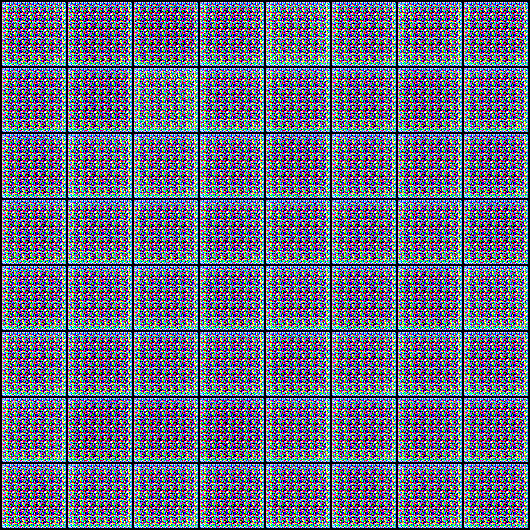

In [ ]:
from IPython.display import Image
Image('./gan_pokemon/pokemon_generated_0001.png')

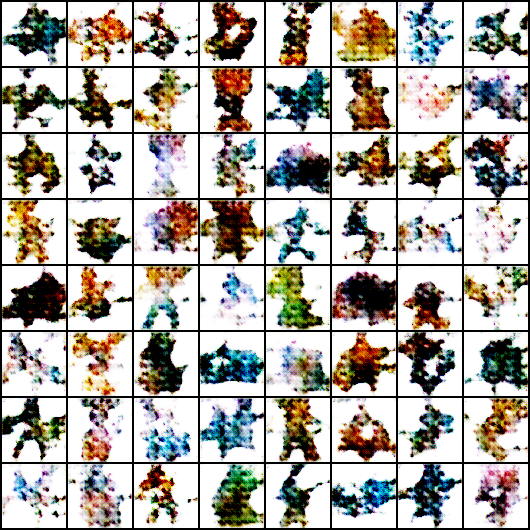

In [ ]:
Image('./gan_pokemon/pokemon_generated_0100.png')

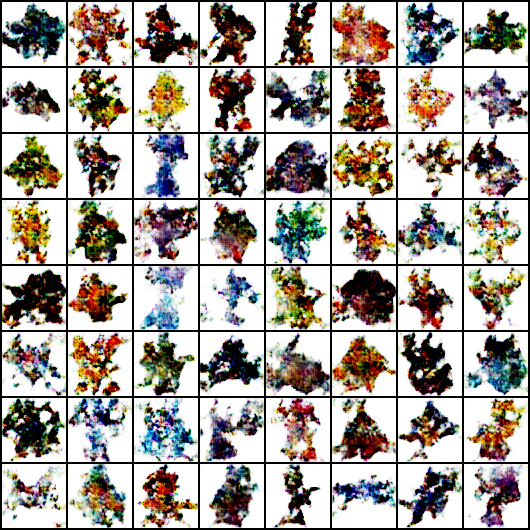

In [ ]:
Image('./gan_pokemon/pokemon_generated_0200.png')

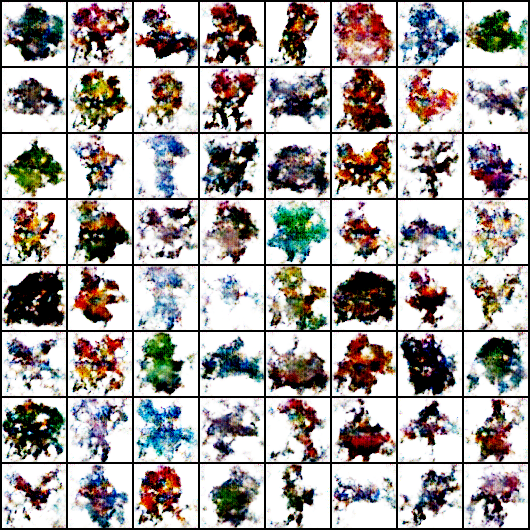

In [ ]:
Image('./gan_pokemon/pokemon_generated_0300.png')

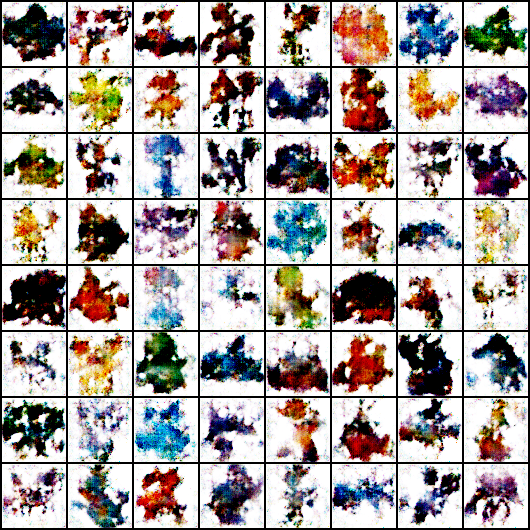

In [ ]:
Image('./gan_pokemon/pokemon_generated_0400.png')

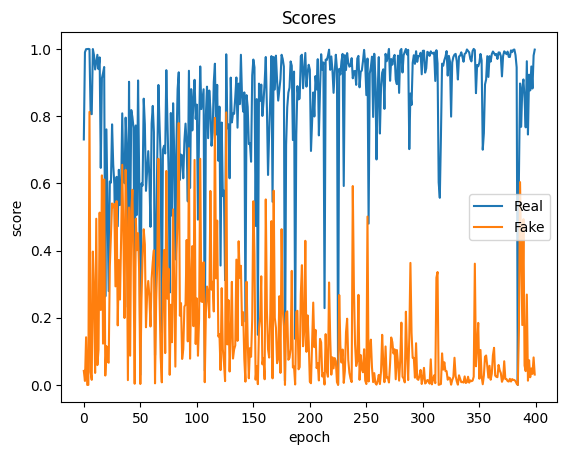

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');
plt.savefig("scores.pdf")

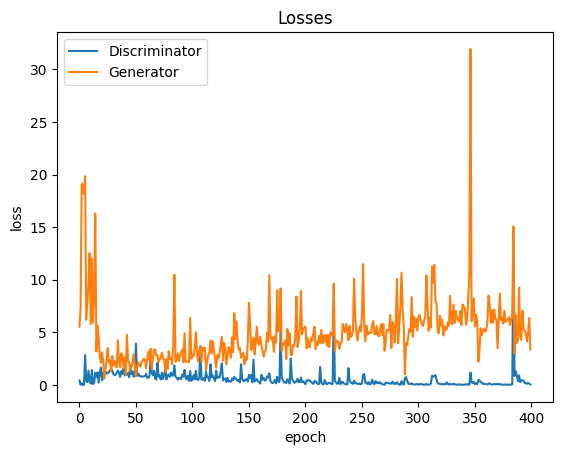

In [ ]:
plt.plot(discriminator_losses, '-')
plt.plot(generator_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');
plt.savefig("losses.pdf")

In [ ]:
# !zip -r new_gan_pokemon gan_pokemon

  adding: gan_pokemon/ (stored 0%)
  adding: gan_pokemon/pokemon_generated_0299.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0042.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0154.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0205.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0106.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0282.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0078.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0238.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0130.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0207.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0202.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0343.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0330.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0135.png (deflated 0%)
  adding: gan_pokemon/pokemon_generated_0009.png (deflated 0%)
  adding: gan_pokemo